In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

torch.cuda.is_available()


False

In [2]:
# Combined dataset: bikes for short distances, cars for longer ones
distances = torch.tensor([
    [1.0], [1.5], [2.0], [2.5], [3.0], [3.5], [4.0], [4.5], [5.0], [5.5],
    [6.0], [6.5], [7.0], [7.5], [8.0], [8.5], [9.0], [9.5], [10.0], [10.5],
    [11.0], [11.5], [12.0], [12.5], [13.0], [13.5], [14.0], [14.5], [15.0], [15.5],
    [16.0], [16.5], [17.0], [17.5], [18.0], [18.5], [19.0], [19.5], [20.0]
], dtype=torch.float32)

# Corresponding delivery times in minutes
times = torch.tensor([
    [6.96], [9.67], [12.11], [14.56], [16.77], [21.7], [26.52], [32.47], [37.15], [42.35],
    [46.1], [52.98], [57.76], [61.29], [66.15], [67.63], [69.45], [71.57], [72.8], [73.88],
    [76.34], [76.38], [78.34], [80.07], [81.86], [84.45], [83.98], [86.55], [88.33], [86.83],
    [89.24], [88.11], [88.16], [91.77], [92.27], [92.13], [90.73], [90.39], [92.98]
], dtype=torch.float32)

In [3]:
distances_std = distances.std()
distances_mean = distances.mean()

times_std = times.std()
times_mean = times.mean()

distances_norm = (distances-distances_mean)/distances_std
times_norm = (times - times_mean)/times_std

In [4]:
model = nn.Sequential(
    nn.Linear(1,3),
    nn.ReLU(),
    nn.Linear(3,1)
)

In [5]:
loss_function = nn.MSELoss()
gradient = optim.SGD(model.parameters(),lr=0.01)

In [6]:
for epoches in range(1000):
    gradient.zero_grad()

    output = model(distances_norm)

    loss = loss_function(output, times_norm)

    loss.backward()

    gradient.step()

    if (epoches + 1) % 50 == 0:
        print(f"Epoch : {epoches+1} and Loss :{loss.item()}" )
        

print("\nTraining Complete.")
print(f"\nFinal Loss: {loss.item()}")


Epoch : 50 and Loss :0.5651528835296631
Epoch : 100 and Loss :0.2961590588092804
Epoch : 150 and Loss :0.14635375142097473
Epoch : 200 and Loss :0.07368024438619614
Epoch : 250 and Loss :0.04094141349196434
Epoch : 300 and Loss :0.026829881593585014
Epoch : 350 and Loss :0.020816726610064507
Epoch : 400 and Loss :0.017968837171792984
Epoch : 450 and Loss :0.016489338129758835
Epoch : 500 and Loss :0.015624321065843105
Epoch : 550 and Loss :0.015039408579468727
Epoch : 600 and Loss :0.01459487620741129
Epoch : 650 and Loss :0.01423056423664093
Epoch : 700 and Loss :0.013918861746788025
Epoch : 750 and Loss :0.013520519249141216
Epoch : 800 and Loss :0.013058059848845005
Epoch : 850 and Loss :0.01264489907771349
Epoch : 900 and Loss :0.01227481383830309
Epoch : 950 and Loss :0.01194242388010025
Epoch : 1000 and Loss :0.011643080040812492

Training Complete.

Final Loss: 0.011643080040812492


In [7]:
new_d = 5.1
""

In [8]:
with torch.no_grad():
    new_distance = torch.tensor([[new_d]], dtype=torch.float32)

    new_dist_norm = (new_distance - distances_mean)/distances_std

    output = model(new_dist_norm)

    outputnorm = (output*times_std) + times_mean

    print(f"You need {outputnorm} to reach {new_d}")

You need tensor([[37.4755]]) to reach 5.1


In [9]:
path = "./datasets./data_with_features.csv"
data = pd.read_csv(path)
data.shape

(100, 4)

In [10]:
data.head()

,distance_miles,time_of_day_hours,is_weekend,delivery_time_minutes
0,1.60,8.20,0,7.22
1,13.09,16.80,1,32.41
2,6.97,8.02,1,17.47
3,10.66,16.07,0,37.17
4,18.24,13.47,0,38.36


In [11]:
def rush_hour_features(hours, weekends):
    is_morning_rush = (hours >= 8) & (hours <= 10)
    is_evening_rush = (hours >= 16) & (hours <= 19)

    is_weekday = weekends == 0

    rush_hour_mask = (is_morning_rush | is_evening_rush) & is_weekday

    return rush_hour_mask.unsqueeze(1).float()


In [12]:
def prep_data(df):

    all_values = df.values

    tensors = torch.tensor(all_values, dtype = torch.float32)

    raw_dist = tensors[:, 0]
    raw_hours = tensors[:, 1]
    raw_weekends=tensors[:, 2]
    raw_targets = tensors[:, 3]

    is_rush_hr = rush_hour_features(raw_hours, raw_weekends)  # Correct
    dist = raw_dist.unsqueeze(1)
    hrs = raw_hours.unsqueeze(1)
    weeknd = raw_weekends.unsqueeze(1)
    rush_hr = is_rush_hr

    dist_std, dist_mean = dist.std(), dist.mean()
    hrs_std, hrs_mean = hrs.std(), hrs.mean()

    dist_norm = (dist - dist_mean)/ dist_std
    hrs_norm = (hrs- hrs_mean)/ hrs_std

    features = torch.cat([
        dist_norm,
        hrs_norm,
        weeknd,
        rush_hr],
        dim = 1
    )

    targets = raw_targets.unsqueeze(1)

    return_dict = {
        'full_tensor': tensors,
        'raw_distances': raw_dist,
        'raw_hours': raw_hours,
        'raw_weekends': raw_weekends,
        'raw_targets': raw_targets,
        'distances_col': dist,
        'hours_col': hrs,
        'weekends_col': weeknd,
        'rush_hour_col': rush_hr
    }

    return features, targets, return_dict

In [13]:
# Create a small test DataFrame with the first 5 entries
test_df = data.head(5).copy()

# Print the "Before" state as a raw tensor
raw_test_tensor = torch.tensor(data.values, dtype=torch.float32)
print("--- Raw Tensor (Before Preparation) ---\n")
print(f"Shape: {raw_test_tensor.shape}")
print("Values:\n", raw_test_tensor)
print("\n" + "="*50 + "\n")

# Run the function to get the prepared "after" tensors
test_features, test_targets, _ = prep_data(test_df)

# Print the "After" state
print("--- Prepared Tensors (After Preparation) ---")
print("\n--- Prepared Features ---\n")
print(f"Shape: {test_features.shape}")
print("Values:\n", test_features)

print("\n--- Prepared Targets ---")
print(f"Shape: {test_targets.shape}")
print("Values:\n", test_targets)

--- Raw Tensor (Before Preparation) ---

Shape: torch.Size([100, 4])
Values:
 tensor([[ 1.6000,  8.2000,  0.0000,  7.2200],
        [13.0900, 16.8000,  1.0000, 32.4100],
        [ 6.9700,  8.0200,  1.0000, 17.4700],
        [10.6600, 16.0700,  0.0000, 37.1700],
        [18.2400, 13.4700,  0.0000, 38.3600],
        [ 5.7400, 16.5900,  0.0000, 29.0600],
        [ 8.8000, 12.2500,  0.0000, 23.9400],
        [15.3600, 11.7600,  1.0000, 32.4000],
        [ 5.3500,  9.4200,  0.0000, 17.0600],
        [ 2.4600, 14.4400,  0.0000, 14.0900],
        [ 6.5100,  8.0000,  0.0000, 33.3800],
        [ 4.0600,  9.3300,  1.0000, 17.3800],
        [18.6600, 14.8600,  1.0000, 36.7500],
        [16.3500, 19.0900,  0.0000, 38.8600],
        [13.0300, 13.4200,  0.0000, 32.5500],
        [17.5600, 18.9200,  0.0000, 61.8700],
        [16.2700, 15.2600,  0.0000, 38.0800],
        [ 4.5400,  9.1000,  0.0000, 24.1200],
        [17.9600, 15.2000,  0.0000, 43.2100],
        [11.2500,  8.0000,  0.0000, 41.0300],
  

In [14]:
features, targets, _ = prep_data(data)

In [15]:
def new_model():

    model = nn.Sequential(
        nn.Linear(4,64),
        nn.ReLU(),
        nn.Linear(64,32),
        nn.ReLU(),
        nn.Linear(32,1)
    )
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    loss_function = nn.MSELoss()


    return model, optimizer, loss_function

In [16]:
model, optimizer, loss_function = new_model()

print(f"{'='*30}\nInitialized Model Architecture\n{'='*30}\n{model}")
print(f"\n{'='*30}\nOptimizer\n{'='*30}\n{optimizer}")
print(f"\n{'='*30}\nLoss Function\n{'='*30}\n{loss_function}")

Initialized Model Architecture
Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
)

Optimizer
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

Loss Function
MSELoss()


In [17]:
def tarin(features, targets, epochs, verbose = True):

    losses= []

    model, optimizer, loss_function = new_model()

    for epoch in range(epochs):
        output = model(features)
        loss = loss_function(output, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

         # Every 5000 epochs, record the loss and print the progress
        if (epoch + 1) % 5000 == 0:
            losses.append(loss.item())
            if verbose:
                print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    
    return model, losses

In [18]:
test_model = tarin(features, targets,10000)

Epoch [5000/10000], Loss: 4.0634
Epoch [10000/10000], Loss: 1.9242


In [19]:
# Training loop
model, loss = tarin(features, targets, 30000)

Epoch [5000/30000], Loss: 4.2364
Epoch [10000/30000], Loss: 2.9529


KeyboardInterrupt: 

In [20]:
# Disable gradient calculation for efficient predictions
with torch.no_grad():
    # Perform a forward pass to get model predictions
    predicted_outputs = model(features)

*DAY 2*


In [1]:
import torch
import torch.nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using device: MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print(f"Using device: CPU")

Using device: CPU


In [3]:
path = "./datasets"

In [4]:
train_dataset_no_trsfm = torchvision.datasets.MNIST(
    root = path,
    train = True,
    download = True
)

In [5]:
image_pil, label = train_dataset_no_trsfm[0]

print(f"Image type:    {type(image_pil)}")
print(f"Image Dimension: {image_pil.size}")
print(f"Label type:  {type(label)}")
print(f"Label Vlaue:  {label}")

Image type:    <class 'PIL.Image.Image'>
Image Dimension: (28, 28)
Label type:  <class 'int'>
Label Vlaue:  5


In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.01307), (0.3081))
])

In [7]:
traind_data= torchvision.datasets.MNIST(
    root = path,
    train = True,
    download  = True,
    transform = transform
)

In [8]:
# Access the first item again
image_tensor, label = traind_data[0]

print(f"Image Type:                   {type(image_tensor)}")
# Since the `image` is now a PyTorch Tensor, its dimensions are accessed using the .shape attribute.
print(f"Image Shape After Transform:  {image_tensor.shape}")
print(f"Label Type:                   {type(label)}")
print(f"Label value:                  {label}")

Image Type:                   <class 'torch.Tensor'>
Image Shape After Transform:  torch.Size([1, 28, 28])
Label Type:                   <class 'int'>
Label value:                  5


In [9]:
test_data = torchvision.datasets.MNIST(
    root = path,
    train = False,
    download = True,
    transform = transform
)

In [10]:
train_dt_ldr = DataLoader(traind_data, batch_size = 32, shuffle = True)

test_dt_ldr = DataLoader(test_data, batch_size = 64, shuffle = False)

In [17]:
import torch.nn as nn
class SimpleMNISTNN(nn.Module):
    def __init__(self):
        super(SimpleMNISTNN, self).__init__()

        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(784,128),
            nn.ReLU(),
            nn.Linear(128,10)
        )

    def forward(self, x):

        x = self.flatten(x)
        x = self.layers(x)
        return x

In [18]:
model = SimpleMNISTNN()

loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [26]:
def train_epoches(model, loss_function, optimizer, train_loader, device):
    model.to(device)
    model.train()

    epoch_loss = 0.0
    running_loss = 0.0
    total_preds = 0
    num_correct_preds =0
    total_batches = len(train_loader)

    for batch_idx, (input, targets) in enumerate(train_loader):

        input, targets = input.to(device), targets.to(device)

        optimizer.zero_grad()

        output = model(input)
        loss = loss_function(output, targets)
        loss.backward()
        optimizer.step()

        loss_valu = loss.item()
        epoch_loss +=loss_valu
        running_loss += loss_valu

        _, predicted_indices = output.max(1)
        batch_size = targets.size(0)
        total_preds += batch_size
        num_correct_preds += predicted_indices.eq(targets).sum().item()

        if (batch_idx + 1) % 134 == 0 or (batch_idx + 1) == total_batches:
            # Calculate average loss and accuracy for the current interval
            avg_running_loss = running_loss / 134
            accuracy = 100 * (num_correct_preds / total_preds)

            # Print the progress update
            print(f'\tStep {batch_idx + 1}/{total_batches} - Loss: {avg_running_loss:.3f} | Acc: {accuracy:.2f}%')

            # Reset the trackers for the next reporting interval
            running_loss = 0.0
            num_correct_preds = 0
            total_preds = 0

    # Calculate the average loss for the entire epoch
    avg_epoch_loss = epoch_loss / total_batches
    # Return the trained model and the average epoch loss
    return model, avg_epoch_loss


In [30]:
def evaluate(model, test_loader, device):
    model.eval()
    model.to(device)

    num_crct_preds = 0
    total_predfs = 0

    with torch.no_grad():

        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)
            _, predicted_indices = torch.max(output, 1)
            batch_size = targets.size(0)
            total_predfs += batch_size
            num_crct_preds += predicted_indices.eq(targets).sum().item()

        accuracy_percent = (num_crct_preds/total_predfs)*100
        print((f'\tAccuracy - {accuracy_percent:.2f}%'))

        return accuracy_percent

In [31]:
num_epochs = 5


train_losss = []
test_acc = []

for epoch in range(num_epochs):

    print(f"Epoch {epoch+1}")

    trained_model, loss = train_epoches(model, loss_function, optimizer, train_dt_ldr, device)

    train_losss.append(loss)
    print(
         f"Testing Epoch {epoch+1}")

    accuracy = evaluate(trained_model, test_dt_ldr, device)
    test_acc.append(accuracy)

Epoch 1
	Step 134/1875 - Loss: 0.062 | Acc: 98.34%
	Step 268/1875 - Loss: 0.059 | Acc: 97.95%
	Step 402/1875 - Loss: 0.068 | Acc: 97.74%
	Step 536/1875 - Loss: 0.070 | Acc: 97.90%
	Step 670/1875 - Loss: 0.064 | Acc: 97.90%
	Step 804/1875 - Loss: 0.068 | Acc: 97.71%
	Step 938/1875 - Loss: 0.066 | Acc: 97.85%
	Step 1072/1875 - Loss: 0.060 | Acc: 98.04%
	Step 1206/1875 - Loss: 0.064 | Acc: 97.99%
	Step 1340/1875 - Loss: 0.062 | Acc: 97.99%
	Step 1474/1875 - Loss: 0.071 | Acc: 97.55%
	Step 1608/1875 - Loss: 0.064 | Acc: 97.85%
	Step 1742/1875 - Loss: 0.067 | Acc: 97.81%
	Step 1875/1875 - Loss: 0.057 | Acc: 98.10%
Testing Epoch 1
	Accuracy - 97.34%
Epoch 2
	Step 134/1875 - Loss: 0.046 | Acc: 98.48%
	Step 268/1875 - Loss: 0.040 | Acc: 98.60%
	Step 402/1875 - Loss: 0.053 | Acc: 98.44%
	Step 536/1875 - Loss: 0.057 | Acc: 98.39%
	Step 670/1875 - Loss: 0.043 | Acc: 98.32%
	Step 804/1875 - Loss: 0.057 | Acc: 98.16%
	Step 938/1875 - Loss: 0.044 | Acc: 98.48%
	Step 1072/1875 - Loss: 0.050 | Acc: 98

#Day 3#

In [4]:
import os
import tarfile
import matplotlib.pyplot as plt
import numpy as np
import requests
import scipy
from PIL import Image
from torch.utils.data import Dataset, Subset, random_split, DataLoader
from torchvision import transforms


In [5]:
import os
import requests
import tarfile
from tqdm import tqdm  # <-- This was missing!

def download_dataset():
    """
    Downloads and extracts the Oxford 102 Flower dataset if not already present locally.
    Source: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/
    """
    # Define the directory to store the dataset
    data_dir = "flower_data"
    image_folder_path = os.path.join(data_dir, "jpg")
    labels_file_path = os.path.join(data_dir, "imagelabels.mat")
    tgz_path = os.path.join(data_dir, "102flowers.tgz")

    # Check if dataset already exists
    if os.path.exists(image_folder_path) and os.path.exists(labels_file_path):
        print(f"Dataset already exists. Loading locally from '{data_dir}'.")
        return

    print("Dataset not found locally. Downloading...")

    # URLs
    image_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
    labels_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"

    # Create directory
    os.makedirs(data_dir, exist_ok=True)

    # Download images with progress bar
    print("Downloading images (~330 MB)...")
    response = requests.get(image_url, stream=True)
    response.raise_for_status()  # Raise an exception for bad status
    total_size = int(response.headers.get("content-length", 0))

    with open(tgz_path, "wb") as file:
        # tqdm progress bar (note: unit='KB' for clarity)
        for data in tqdm(response.iter_content(chunk_size=1024),
                         total=total_size // 1024,
                         unit='KB',
                         unit_scale=True):
            file.write(data)

    # Extract tar.gz
    print("Extracting images...")
    with tarfile.open(tgz_path, "r:gz") as tar:
        tar.extractall(path=data_dir)

    # Download labels
    print("Downloading labels...")
    response = requests.get(labels_url)
    response.raise_for_status()
    with open(labels_file_path, "wb") as file:
        file.write(response.content)

    print(f"Dataset successfully downloaded and extracted to '{data_dir}'.")

# Run it
download_dataset()

Dataset already exists. Loading locally from 'flower_data'.


In [6]:
# Define the path to the root directory of the dataset.
path_dataset = './flower_data'

# Display the folder structure of the dataset directory up to a depth of one.

In [7]:
class FlowerDataset(Dataset):

    def __init__(self, root_dir, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        self.image_dir = os.path.join(root_dir, 'jpg')
        self.labels = self.load_and_correct_labels()

    def __len__(self):

        return len(self.labels)

    def __getitem__(self, idx):
        image = self.retrieve_image(idx)
        if self.transform is not None:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

    def retrieve_image(self ,idx):
        img_name = f"image_{idx+1:05d}.jpg"

        image_path = os.path.join(self.image_dir, img_name)

        with Image.open(image_path) as img:
            image = img.convert("RGB")
        return image
    def load_and_correct_labels(self):
        self.labels_mat = scipy.io.loadmat(
            os.path.join(self.root_dir, 'imagelabels.mat')
        )

        labels = self.labels_mat['labels'][0]-1
        return labels

    def get_label_description(self,label):
        path_labels_description = os.path.join(self.root_dir, 'label_description.txt')

        with open(path_labels_description, 'r') as f:
            lines = f.readlines()
        description = lines[label].strip()

        return description


In [8]:
# Initialize the dataset object, providing the path to the data.
dataset = FlowerDataset(path_dataset)

In [9]:
# Print the total number of samples in the dataset.
print(f'Number of samples in the dataset: {len(dataset)}\n')

Number of samples in the dataset: 8189



In [10]:
# Define an index for a sample to retrieve.
sel_idx = 10

# Retrieve the image and label for the selected index.
img, label = dataset[sel_idx]

In [11]:
# Create a string detailing the image's dimensions.
img_size_info = f"Image size: {img.size}"

# Print the image size information along with its corresponding label.
print(f'{img_size_info}, Label: {label}\n')

Image size: (500, 748), Label: 76



In [12]:
# Get all labels from the dataset object.
dataset_labels = dataset.labels

# Create a set of unique labels to remove duplicates.
unique_labels = set(dataset_labels)

# Iterate through each unique label.
for label in unique_labels:
    # Print the numerical label and its corresponding text description.
    print(f'Label: {label}, Description: {dataset.get_label_description(label)}')

FileNotFoundError: [Errno 2] No such file or directory: './flower_data\\label_description.txt'

In [13]:


def visual_exploration(dataset, num_rows=2, num_cols=4):
    """
    Displays a grid of randomly selected samples from a dataset for visual inspection.

    Args:
        dataset: The dataset object from which to draw samples. It should support
                 indexing and have a `get_label_description` method.
        num_rows (int): The number of rows in the display grid.
        num_cols (int): The number of columns in the display grid.
    """
    # Calculate the total number of images to display in the grid.
    total_samples = num_rows * num_cols

    # Select a random set of unique indices from the dataset.
    indices = np.random.choice(len(dataset), total_samples, replace=False)

    # Create a grid of subplots to hold the images.
    fig, axes = helper_utils.get_grid(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 4))

    # Iterate over each subplot axis and the corresponding random sample index.
    for ax, idx in zip(axes.flatten(), indices):
        # Retrieve the image and its numerical label from the dataset.
        image, label = dataset[idx]

        # Get the human-readable text description for the label.
        description = dataset.get_label_description(label)

        # Format a new label string that includes both the number and description.
        label = f"{label} - {description}"

        # Create an information string with the sample's index and image dimensions.
        info = f"Index: {idx} Size: {image.size}"

        # Plot the image on the current subplot with its label and info.
        helper_utils.plot_img(image, label=label, info=info, ax=ax)

    # Render and display the entire grid of images.
    plt.show()

In [14]:
# Define the mean values for normalization.
mean = [0.485, 0.456, 0.406]
# Define the standard deviation values for normalization.
std = [0.229, 0.224, 0.225]

In [15]:
transform = transforms.Compose([
    # images transforms
    transforms.Resize((256, 256)),  # Resize images to 256x256 pixels
    transforms.CenterCrop(224),  # Center crop to 224x224 pixels
    # bridge to tensor
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    # tensor transforms
    transforms.Normalize(mean=mean, std=std),
])

In [16]:
# Create a new dataset instance with the specified image transformations.
dataset_transformed = FlowerDataset(path_dataset, transform=transform)

In [18]:
class Denormalize:
    """
    A callable class to reverse the normalization of a tensor image.

    This class calculates the inverse transformation of a standard normalization
    and can be used as a transform step, for instance, to visualize images
    after they have been normalized for a model.
    """
    def __init__(self, mean, std):
        """
        Initializes the denormalization transform.

        Args:
            mean (list or tuple): The mean values used for the original normalization.
            std (list or tuple): The standard deviation values used for the original
                                 normalization.
        """
        # Calculate the adjusted mean for the denormalization process.
        new_mean = [-m / s for m, s in zip(mean, std)]
        # Calculate the adjusted standard deviation for the denormalization process.
        new_std = [1 / s for s in std]
        # Create a Normalize transform object with the inverse parameters.
        self.denormalize = transforms.Normalize(mean=new_mean, std=new_std)

    def __call__(self, tensor):
        """
        Applies the denormalization transform to a tensor.

        Args:
            tensor: The normalized tensor to be denormalized.

        Returns:
            The denormalized tensor.
        """
        # Apply the denormalization transform to the input tensor.
        return self.denormalize(tensor)

In [19]:
img_transformed, label = dataset_transformed[sel_idx]


In [20]:
# Create an instance of the Denormalize class with the original mean and std.
denormalize = Denormalize(mean=mean, std=std)
# Apply the denormalization transform to the image tensor.
img_tensor = denormalize(img_transformed)

In [21]:
def split_dataset(dataset, val_fraction=0.15, test_fraction=0.15):
    """
    Split the dataset into training, validation, and test sets.

    By default, this function splits the data into 70% for training,
    15% for validation, and 15% for testing.
    """

    # Calculate the sizes of each split.
    total_size = len(dataset)
    val_size = int(total_size * val_fraction)
    test_size = int(total_size * test_fraction)
    train_size = total_size - val_size - test_size

    # Use random_split to create the datasets.
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )
    return train_dataset, val_dataset, test_dataset

In [22]:
train_dataset, val_dataset, test_dataset = split_dataset(dataset_transformed)

In [23]:
print(f"Length of training dataset:   {len(train_dataset)}")
print(f"Length of validation dataset: {len(val_dataset)}")
print(f"Length of test dataset:       {len(test_dataset)}")

Length of training dataset:   5733
Length of validation dataset: 1228
Length of test dataset:       1228


In [24]:
# Set the batch size for the data loaders.
batch_size = 32

# Create the DataLoader for the training set, with shuffling enabled.
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Create the DataLoader for the validation set, with shuffling disabled.
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# Create the DataLoader for the test set, with shuffling disabled.
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
def get_augmentation_transform(mean, std):
    """
    Creates and returns a composition of image transformations for data augmentation
    and preprocessing.

    Args:
        mean (list or tuple): A sequence of mean values for each channel.
        std (list or tuple): A sequence of standard deviation values for each channel.

    Returns:
        torchvision.transforms.Compose: A composed pipeline of transformations.
    """
    # Define a list of data augmentation transformations to be applied randomly.
    augmentations_transforms = [
        # Randomly flip the image horizontally with a 50% probability.
        transforms.RandomHorizontalFlip(p=0.5),
        # Randomly rotate the image within a range of +/- 10 degrees.
        transforms.RandomRotation(degrees=10),
        # Randomly adjust the brightness of the image.
        transforms.ColorJitter(brightness=0.2),
    ]

    # Define the main list of standard, non-random transformations.
    main_transforms = [
        # Resize the input image to 256x256 pixels.
        transforms.Resize((256, 256)),
        # Crop the center 224x224 pixels of the image.
        transforms.CenterCrop(224),
        # Convert the PIL Image to a PyTorch tensor.
        transforms.ToTensor(),
        # Normalize the tensor with the provided mean and standard deviation.
        transforms.Normalize(mean=mean, std=std),
    ]

    # Combine the augmentation and main transformations into a single pipeline.
    transform = transforms.Compose(augmentations_transforms + main_transforms)
    # Return the final composed transform object.
    return transform

In [26]:
# Create the augmentation and preprocessing pipeline, providing the normalization stats.
augmentation_transform = get_augmentation_transform(mean=mean, std=std)

# Initialize a new dataset instance that will use the augmentation pipeline.
dataset_augmented = FlowerDataset(path_dataset, transform=augmentation_transform)

In [27]:
class SubsetWithTransform(Dataset):
    """
    A wrapper for a PyTorch Subset that applies a specific transformation.

    This class allows for applying a different set of transformations to a
    subset of a dataset, which is useful for creating distinct training,
    validation, or test sets with different preprocessing steps from the
    same base dataset.
    """
    def __init__(self, subset, transform=None):
        """
        Initializes the SubsetWithTransform object.

        Args:
            subset: A PyTorch Subset object containing a portion of a dataset.
            transform (callable, optional): An optional transform to be applied
                to the samples within this subset.
        """
        # Store the original subset of the dataset.
        self.subset = subset
        # Store the transformations to be applied.
        self.transform = transform

    def __len__(self):
        """
        Returns the total number of samples in the subset.
        """
        # Return the length of the underlying subset.
        return len(self.subset)

    def __getitem__(self, idx):
        """
        Retrieves a sample and applies the transform.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the transformed image and its label.
        """
        # Get the original image and label from the underlying subset.
        image, label = self.subset[idx]
        # Check if a transform has been provided.
        if self.transform:
            # Apply the transform to the image.
            image = self.transform(image)
        # Return the transformed image and its label.
        return image, label

In [28]:
# Apply the augmentation pipeline to the training subset.
train_dataset = SubsetWithTransform(train_dataset, transform=augmentation_transform)
# Apply the basic preprocessing transform to the validation subset.
val_dataset = SubsetWithTransform(val_dataset, transform=transform)
# Apply the basic preprocessing transform to the test subset.
test_dataset = SubsetWithTransform(test_dataset, transform=transform)

In [29]:
print(train_dataset.transform)
print(val_dataset.transform)
print(test_dataset.transform)

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.8, 1.2), contrast=None, saturation=None, hue=None)
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [30]:
class RobustFlowerDataset(Dataset):
    """
    A custom dataset class with robust error handling for loading images.

    This class is designed to gracefully handle issues with individual data
    samples, such as corrupted files or incorrect formats. It logs any errors
    and attempts to load a different sample instead of crashing.
    """
    def __init__(self, root_dir, transform=None):
        """
        Initializes the dataset object.

        Args:
            root_dir (str): The root directory where the dataset is stored.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        # Store the root directory path.
        self.root_dir = root_dir
        # Construct the full path to the image directory.
        self.img_dir = os.path.join(root_dir, "jpg")
        # Store the optional transformations.
        self.transform = transform
        # Load and process the labels from the corresponding file.
        self.labels = self.load_and_correct_labels()
        # Initialize a list to keep track of any errors encountered.
        self.error_logs = []

    def __getitem__(self, idx):
        """
        Retrieves a sample, handling errors by trying the next available item.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the image and its label.
        """
        # Loop to attempt loading a valid sample, preventing an infinite loop.
        for attempt in range(len(self)):
            # Attempt to load and process the sample.
            try:
                # Retrieve the image using the helper method.
                image = self.retrieve_image(idx)
                # Check if a transform has been provided.
                if self.transform:
                    # Apply the transform to the image.
                    image = self.transform(image)
                # Get the label for the current index.
                label = self.labels[idx]
                # Return the valid image and its corresponding label.
                return image, label
            # Catch any exception that occurs during the process.
            except Exception as e:
                # Log the error with its index and message.
                self.log_error(idx, e)
                # Move to the next index, wrapping around if necessary.
                idx = (idx + 1) % len(self)

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        # The total number of samples is the number of labels.
        return len(self.labels)

    def retrieve_image(self, idx):
        """
        Loads and validates a single image from disk.

        Args:
            idx (int): The index of the image to load.

        Returns:
            PIL.Image.Image: The validated and loaded image object.
        """
        # Construct the image filename based on the index.
        img_name = f"image_{idx+1:05d}.jpg"
        # Construct the full path to the image file.
        img_path = os.path.join(self.img_dir, img_name)
        # Open the image file to check its integrity without loading fully.
        with Image.open(img_path) as img:
            # Perform a quick verification of the file's structure.
            img.verify()
        # Re-open the image file after successful verification.
        image = Image.open(img_path)
        # Fully load the image data into memory.
        image.load()
        # Check if the image dimensions are below a minimum threshold.
        if image.size[0] < 32 or image.size[1] < 32:
            # Raise an error for images that are too small.
            raise ValueError(f"Image too small: {image.size}")
        # Check if the image is not in the RGB color mode.
        if image.mode != "RGB":
            # Convert the image to RGB.
            image = image.convert("RGB")
        # Return the fully loaded and validated image.
        return image

    def load_and_correct_labels(self):
        """
        Loads labels from a .mat file and adjusts them.

        Returns:
            numpy.ndarray: An array of zero-indexed integer labels.
        """
        # Load the MATLAB file containing the labels.
        self.labels_mat = scipy.io.loadmat(
            os.path.join(self.root_dir, "imagelabels.mat")
        )
        # Extract the labels array and correct for zero-based indexing.
        labels = self.labels_mat["labels"][0] - 1
        # Truncate the dataset to the first 10 labels for quick testing.
        labels = labels[:10]
        # Return the processed labels.
        return labels

    def log_error(self, idx, e):
        """
        Records the details of an error encountered during data loading.

        Args:
            idx (int): The index of the problematic sample.
            e (Exception): The exception object that was raised.
        """
        # Construct the filename of the problematic image.
        img_name = f"image_{idx + 1:05d}.jpg"
        # Construct the full path to the image file.
        img_path = os.path.join(self.img_dir, img_name)
        # Append a dictionary with error details to the log.
        self.error_logs.append(
            {
                "index": idx,
                "error": str(e),
                "path": img_path if "img_path" in locals() else "unknown",
            }
        )
        # Print a warning to the console about the skipped image.
        print(f"Warning: Skipping corrupted image {idx}: {e}")

    def get_error_summary(self):
        """
        Prints a summary of all errors encountered during dataset processing.
        """
        # Check if the error log is empty.
        if not self.error_logs:
            # Print a message indicating the dataset is clean.
            print("No errors encountered - dataset is clean!")
        else:
            # Print the total number of problematic images found.
            print(f"\nEncountered {len(self.error_logs)} problematic images:")
            # Iterate through the first few logged errors.
            for error in self.error_logs[:5]:
                # Print the details of an individual error.
                print(f"  Index {error['index']}: {error['error']}")
            # Check if there are more errors than were displayed.
            if len(self.error_logs) > 5:
                # Print a summary of the remaining errors.
                print(f"  ... and {len(self.error_logs) - 5} more")

In [32]:
# Define the path to the directory containing the corrupted dataset.
corrupted_dataset_path = './flower_data'

# Initialize the robust dataset handler with the path to the corrupted data.
robust_dataset = RobustFlowerDataset(corrupted_dataset_path)

In [33]:
class MonitoredDataset(RobustFlowerDataset):
    """
    Extends a robust dataset class to add performance monitoring.

    This class tracks metrics such as how frequently each image is accessed,
    how long each access takes, and which images are never loaded. It provides
    a summary of these statistics to help diagnose data pipeline issues.
    """
    def __init__(self, *args, **kwargs):
        """
        Initializes the monitored dataset object.

        Args:
            *args: Variable length argument list passed to the parent class.
            **kwargs: Arbitrary keyword arguments passed to the parent class.
        """
        # Initialize the parent class with all provided arguments.
        super().__init__(*args, **kwargs)
        # Initialize a dictionary to count how many times each index is accessed.
        self.access_counts = {}
        # Initialize a list to store the load time for each access.
        self.load_times = []

    def __getitem__(self, idx):
        """
        Retrieves a sample while monitoring access counts and load times.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: The data sample (e.g., image and label) from the parent class.
        """
        # Import the time module for timing operations.
        import time
        # Record the start time of the operation.
        start_time = time.time()
        # Increment the access count for the given index.
        self.access_counts[idx] = self.access_counts.get(idx, 0) + 1
        # Call the parent class's method to load the data.
        result = super().__getitem__(idx)
        # Calculate the total time taken to load the sample.
        load_time = time.time() - start_time
        # Append the calculated load time to the list.
        self.load_times.append(load_time)
        # Check if the load time exceeds a certain threshold.
        if load_time > 1.0:
            # Print a warning if a slow load time is detected.
            print(f"⚠️ Slow load: Image {idx} took {load_time:.2f}s")
        # Return the loaded sample from the parent class.
        return result

    def print_stats(self):
        """
        Prints a summary of the dataset's access statistics and performance.
        """
        # Print a header for the statistics report.
        print("\n=== Pipeline Statistics ===")
        # Display the total number of images in the dataset.
        print(f"Total images: {len(self)}")
        # Display the number of unique images that were accessed.
        print(f"Unique images accessed: {len(self.access_counts)}")
        # Display the total number of errors logged by the parent class.
        print(f"Errors encountered: {len(self.error_logs)}")
        # Check if any load times have been recorded.
        if self.load_times:
            # Calculate the average load time.
            avg_time = sum(self.load_times) / len(self.load_times)
            # Find the maximum (slowest) load time.
            max_time = max(self.load_times)
            # Print the average load time in milliseconds.
            print(f"Average load time: {avg_time*1000:.1f} ms")
            # Print the slowest load time in milliseconds.
            print(f"Slowest load: {max_time*1000:.1f} ms")
        # Create a set of all possible indices in the dataset.
        all_indices = set(range(len(self)))
        # Create a set of all indices that were actually accessed.
        accessed_indices = set(self.access_counts.keys())
        # Find the set of indices that were never accessed.
        never_accessed = all_indices - accessed_indices
        # Check if there are any images that were never loaded.
        if never_accessed:
            # Print a warning message with the count of never-accessed images.
            print(f"\n⚠️ WARNING: {len(never_accessed)} images were never loaded!")
            # Show a few examples of the indices that were never accessed.
            print(f"   Examples: {list(never_accessed)[:5]}")

In [34]:
# Initialize the monitored dataset with the path to the potentially corrupted data.
monitored_dataset = MonitoredDataset(corrupted_dataset_path)

# Loop through every index in the dataset to simulate a full pass.
# Iterate through the dataset to trigger monitoring
for idx in range(len(monitored_dataset)):
    # Access the sample at the current index to trigger the monitoring and error-handling logic.
    img, label = monitored_dataset[idx]

In [35]:
# Print the statistics
monitored_dataset.print_stats()


=== Pipeline Statistics ===
Total images: 10
Unique images accessed: 10
Errors encountered: 0
Average load time: 8.9 ms
Slowest load: 34.7 ms


Day 4


In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import SqueezeNet
import helper_utils

In [2]:
dataset = helper_utils.get_dataset()

transform = transforms.ToTensor()
dataset.transform = transform

100%|██████████| 26.4M/26.4M [06:19<00:00, 69.6kB/s]
100%|██████████| 29.5k/29.5k [00:01<00:00, 17.3kB/s]
100%|██████████| 4.42M/4.42M [02:13<00:00, 33.2kB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.9MB/s]


In [3]:
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [5]:
img_batch, label_batch = next(iter(dataloader))
print("Batch shape:", img_batch.shape)  # Should be [batch_size, 1, 28, 28]

Batch shape: torch.Size([64, 1, 28, 28])


In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional Block
        self.conv = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Block
        # For Fashion MNIST: input images are 28x28,
        # after conv+pool: 32x14x14
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.relu_fc = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)  # 10 classes for Fashion MNIST

    def forward(self, x):
        x = self.pool(self.relu(self.conv(x)))
        x = self.relu_fc(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
simple_cnn = SimpleCNN()

try:
    output = simple_cnn(img_batch)
except Exception as e:
    print(f"\033[91mError during forward pass: {e}\033[0m")

Error during forward pass: mat1 and mat2 shapes cannot be multiplied (28672x14 and 6272x128)


In [9]:
class SimpleCNNDebug(SimpleCNN):
    def __init__(self):
        super().__init__()
        # The super().__init__() call above properly initializes all layers from SimpleCNN
        # No need to redefine the layers here

    def forward(self, x):
        print("Input shape:", x.shape)
        print(
            " (Layer components) Conv layer parameters (weights, biases):",
            self.conv.weight.shape,
            self.conv.bias.shape,
        )
        x_conv = self.relu(self.conv(x))

        print("===")

        print("(Activation) After convolution and ReLU:", x_conv.shape)
        x_pool = self.pool(x_conv)
        print("(Activation) After pooling:", x_pool.shape)

        print(
            "(Layer components) Linear layer fc1 parameters (weights, biases):",
            self.fc1.weight.shape,
            self.fc1.bias.shape,
        )

        x_fc1 = self.relu_fc(self.fc1(x_pool))

        print("===")

        print("(Activation) After fc1 and ReLU:", x_fc1.shape)

        print(
            "(Layer components) Linear layer fc2 parameters (weights, biases):",
            self.fc2.weight.shape,
            self.fc2.bias.shape,
        )
        x = self.fc2(x_fc1)

        print("===")

        print("(Activation) After fc2 (output):", x.shape)
        return x

In [10]:
class SimpleCNNFixed(SimpleCNN):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        print("Input shape:", x.shape)
        print(
            " (Neuron components) Conv layer parameters (weights, biases):",
            self.conv.weight.shape,
            self.conv.bias.shape,
        )
        x_conv = self.relu(self.conv(x))

        print("===")

        print("(Activation) After convolution and ReLU:", x_conv.shape)
        x_pool = self.pool(x_conv)
        print("(Activation) After pooling:", x_pool.shape)

        x_flattened = torch.flatten(
            x_pool, start_dim=1
        )  # Flatten all dimensions except batch
        print("(Activation) After flattening:", x_flattened.shape)

        print(
            "(Neuron components) Linear layer fc1 parameters (weights, biases):",
            self.fc1.weight.shape,
            self.fc1.bias.shape,
        )

        x_fc1 = self.relu_fc(self.fc1(x_flattened))

        print("===")

        print("(Activation) After fc1 and ReLU:", x_fc1.shape)

        print(
            "(Neuron components) Linear layer fc2 parameters (weights, biases):",
            self.fc2.weight.shape,
            self.fc2.bias.shape,
        )
        x = self.fc2(x_fc1)

        print("===")

        print("(Activation) After fc2 (output):", x.shape)
        return x

In [11]:
# Fixed version
simple_cnn_fixed = SimpleCNNFixed()

output = simple_cnn_fixed(img_batch)

Input shape: torch.Size([64, 1, 28, 28])
 (Neuron components) Conv layer parameters (weights, biases): torch.Size([32, 1, 3, 3]) torch.Size([32])
===
(Activation) After convolution and ReLU: torch.Size([64, 32, 28, 28])
(Activation) After pooling: torch.Size([64, 32, 14, 14])
(Activation) After flattening: torch.Size([64, 6272])
(Neuron components) Linear layer fc1 parameters (weights, biases): torch.Size([128, 6272]) torch.Size([128])
===
(Activation) After fc1 and ReLU: torch.Size([64, 128])
(Neuron components) Linear layer fc2 parameters (weights, biases): torch.Size([10, 128]) torch.Size([10])
===
(Activation) After fc2 (output): torch.Size([64, 10])


In [13]:
class SimpleCNN2Seq(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional Block
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Fully Connected Block
        # For Fashion MNIST: input images are 28x28,
        # after conv+pool: 32x14x14
        flattened_size = 32 * 14 * 14
        self.fc_block = nn.Sequential(
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Linear(128, 10),  # 10 classes for Fashion MNIST
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = torch.flatten(x, start_dim=1)  # Flatten all dimensions except batch
        x = self.fc_block(x)
        return x

In [14]:
simple_cnn_seq = SimpleCNN2Seq()
output = simple_cnn_seq(img_batch)

print("Output shape from sequential model:", output.shape)

Output shape from sequential model: torch.Size([64, 10])


In [15]:
class SimpleCNN2SeqDebug(SimpleCNN2Seq):
    def __init__(self):
        super().__init__()
        # The super().__init__() call above properly initializes all layers from SimpleCNN2Seq
        # No need to redefine the layers here

    def get_statistics(self, activation):
        mean = activation.mean().item()
        std = activation.std().item()
        min_val = activation.min().item()
        max_val = activation.max().item()

        print(f" Mean: {mean}")
        print(f" Std: {std}")
        print(f" Min: {min_val}")
        print(f" Max: {max_val}")
        return mean, std, min_val, max_val

    def forward(self, x):
        features = self.conv_block(x)
        x = torch.flatten(features, start_dim=1)  # Flatten all dimensions except batch

        print("After conv_block, the activation statistics are:")
        self.get_statistics(features)

        x = self.fc_block(x)
        print("After fc_block, the activation statistics are:")
        self.get_statistics(x)
        return x

In [16]:
simple_cnn_seq_debug = SimpleCNN2SeqDebug()

for idx, (img_batch, _) in enumerate(dataloader):
    if idx < 5:
        print(f"=== Batch {idx} ===")
        output_debug = simple_cnn_seq_debug(img_batch)

=== Batch 0 ===
After conv_block, the activation statistics are:
 Mean: 0.16244833171367645
 Std: 0.2512921094894409
 Min: 0.0
 Max: 1.6010143756866455
After fc_block, the activation statistics are:
 Mean: -0.010181846097111702
 Std: 0.08443908393383026
 Min: -0.2243892252445221
 Max: 0.2109490931034088
=== Batch 1 ===
After conv_block, the activation statistics are:
 Mean: 0.16625601053237915
 Std: 0.2598569095134735
 Min: 0.0
 Max: 1.5589196681976318
After fc_block, the activation statistics are:
 Mean: -0.010676726698875427
 Std: 0.08520328998565674
 Min: -0.25256040692329407
 Max: 0.19538113474845886
=== Batch 2 ===
After conv_block, the activation statistics are:
 Mean: 0.1655958592891693
 Std: 0.2598241865634918
 Min: 0.0
 Max: 1.5621497631072998
After fc_block, the activation statistics are:
 Mean: -0.01023456733673811
 Std: 0.08452366292476654
 Min: -0.23079359531402588
 Max: 0.18412840366363525
=== Batch 3 ===
After conv_block, the activation statistics are:
 Mean: 0.163660749

In [17]:
# Load SqueezeNet model
complex_model = SqueezeNet()

print(complex_model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [19]:
# Iterate through the main blocks
for name, block in complex_model.named_children():
    print(f"Block {name} has a total of {len(list(block.children()))} layers:")

    # List all children layers in the block
    for idx, layer in enumerate(block.children()):
        # Check if the layer is terminal (no children) or not
        if len(list(layer.children())) == 0:
            print(f"\t {idx} - Layer {layer}")
        # If the layer has children, it's a sub-block, then print only the number of children and its name
        else:
            layer_name = layer._get_name()  # More user-friendly name
            print(f"\t {idx} - Sub-block {layer_name} with {len(list(layer.children()))} layers")

Block features has a total of 13 layers:
	 0 - Layer Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
	 1 - Layer ReLU(inplace=True)
	 2 - Layer MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
	 3 - Sub-block Fire with 6 layers
	 4 - Sub-block Fire with 6 layers
	 5 - Sub-block Fire with 6 layers
	 6 - Layer MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
	 7 - Sub-block Fire with 6 layers
	 8 - Sub-block Fire with 6 layers
	 9 - Sub-block Fire with 6 layers
	 10 - Sub-block Fire with 6 layers
	 11 - Layer MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
	 12 - Sub-block Fire with 6 layers
Block classifier has a total of 4 layers:
	 0 - Layer Dropout(p=0.5, inplace=False)
	 1 - Layer Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
	 2 - Layer ReLU(inplace=True)
	 3 - Layer AdaptiveAvgPool2d(output_size=(1, 1))


In [20]:
first_fire_module = complex_model.features[3]

for idx, module in enumerate(first_fire_module.modules()):
    # Avoid printing the top-level module itself
    if idx > 0 :
        print(module)

Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
ReLU(inplace=True)
Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
ReLU(inplace=True)
Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)


In [21]:
type_layer = nn.Conv2d

selected_layers = [layer for layer in complex_model.modules() if isinstance(layer, type_layer)]

print(f"Number of {type_layer.__name__} layers: {len(selected_layers)}")

Number of Conv2d layers: 26


In [22]:
# total number of parameters in the model
total_params = sum(p.numel() for p in complex_model.parameters())
print(f"Total number of parameters in the model: {total_params}")

Total number of parameters in the model: 1248424


Layer features.0 has 14208 parameters
Layer features.1 has 0 parameters
Layer features.2 has 0 parameters
Layer features.3.squeeze has 1552 parameters
Layer features.3.squeeze_activation has 0 parameters
Layer features.3.expand1x1 has 1088 parameters
Layer features.3.expand1x1_activation has 0 parameters
Layer features.3.expand3x3 has 9280 parameters
Layer features.3.expand3x3_activation has 0 parameters
Layer features.4.squeeze has 2064 parameters
Layer features.4.squeeze_activation has 0 parameters
Layer features.4.expand1x1 has 1088 parameters
Layer features.4.expand1x1_activation has 0 parameters
Layer features.4.expand3x3 has 9280 parameters
Layer features.4.expand3x3_activation has 0 parameters
Layer features.5.squeeze has 4128 parameters
Layer features.5.squeeze_activation has 0 parameters
Layer features.5.expand1x1 has 4224 parameters
Layer features.5.expand1x1_activation has 0 parameters
Layer features.5.expand3x3 has 36992 parameters
Layer features.5.expand3x3_activation has 

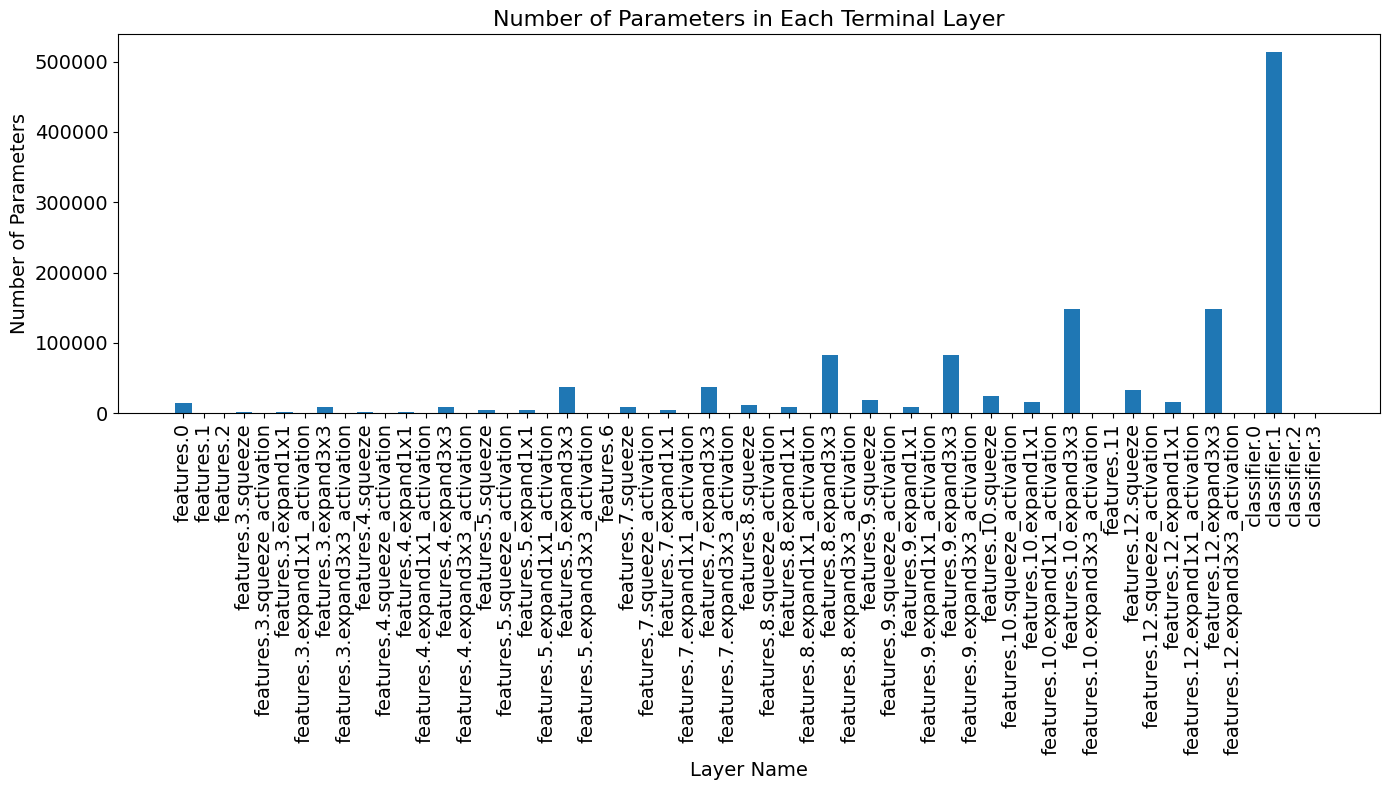

In [23]:
counting_params = {}

# For each terminal layer print its number of parameters
for layer in complex_model.named_modules():
    n_children = len(list(layer[1].children()))
    if n_children == 0:  # Terminal layer
        layer_name = layer[0]
        n_parameters = sum(p.numel() for p in layer[1].parameters())
        counting_params[layer_name] = n_parameters
        print(f"Layer {layer_name} has {n_parameters} parameters")

# Plotting the distribution of parameters per layer
helper_utils1.plot_counting(counting_params)

Day 5


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics

import helper_utils1

helper_utils1.set_seed(42)

In [3]:
# # Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
class SimpleCNN(nn.Module):
    """A simple Convolutional Neural Network (CNN) architecture.

    This class defines a two-layer CNN with max pooling, dropout, and
    fully connected layers, suitable for basic image classification tasks.
    """
    def __init__(self):
        """Initializes the layers of the neural network."""
        # Initialize the parent nn.Module class
        super(SimpleCNN, self).__init__()
        # First convolutional layer (3 input channels, 16 output channels, 3x3 kernel)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        # Second convolutional layer (16 input channels, 32 output channels, 3x3 kernel)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # Max pooling layer with a 2x2 window and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        # First fully connected (linear) layer
        self.fc1 = nn.Linear(32 * 8 * 8, 64)
        # Second fully connected (linear) layer, serving as the output layer
        self.fc2 = nn.Linear(64, 10)
        # Dropout layer for regularization
        self.dropout = nn.Dropout(p=0.4)

    def forward(self, x):
        """Defines the forward pass of the network.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, 3, height, width).

        Returns:
            torch.Tensor: The output logits from the network.
        """
        # Apply first convolution, ReLU activation, and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Apply second convolution, ReLU activation, and max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the feature maps for the fully connected layers
        x = x.view(-1, 32 * 8 * 8)
        # Apply the first fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Apply dropout for regularization
        x = self.dropout(x)
        # Apply the final output layer
        x = self.fc2(x)
        return x


def evaluate_accuracy(model, val_loader, device):
    """Calculates the accuracy of a model on a given dataset.

    Args:
        model (nn.Module): The PyTorch model to be evaluated.
        val_loader (DataLoader): The DataLoader containing the validation or test data.
        device: The device (e.g., 'cuda' or 'cpu') to perform the evaluation on.

    Returns:
        float: The computed accuracy of the model on the dataset.
    """
    # Set the model to evaluation mode
    model.eval()
    # Initialize counters for accuracy calculation
    total_correct = 0
    total_samples = 0

    # Disable gradient computation for evaluation
    with torch.no_grad():
        # Iterate over the data in the provided loader
        for inputs, labels in val_loader:
            # Move input and label tensors to the specified device
            inputs, labels = inputs.to(device), labels.to(device)
            # Perform a forward pass to get model outputs
            outputs = model(inputs)

            # Get the predicted class by finding the index of the maximum logit
            _, predicted = outputs.max(1)
            # Update the count of correctly classified samples
            total_correct += (predicted == labels).sum().item()
            # Update the total number of samples processed
            total_samples += labels.size(0)

    # Calculate the final accuracy
    accuracy = total_correct / total_samples
    # Return the computed accuracy
    return accuracy

In [5]:
def train_and_evaluate(learning_rate, device, n_epochs=25, batch_size=128):
    """Trains and evaluates a model for a specific learning rate and configuration.

    This function orchestrates the entire workflow: it sets a random seed,
    initializes the model, optimizer, and dataloaders, trains the model,
    and finally evaluates its accuracy on a validation set.

    Args:
        learning_rate (float): The learning rate to use for the optimizer.
        device: The device (e.g., 'cuda' or 'cpu') for training and evaluation.
        n_epochs (int, optional): The number of epochs for training. Defaults to 25.
        batch_size (int, optional): The batch size for the dataloaders. Defaults to 128.

    Returns:
        float: The final validation accuracy of the trained model.
    """
    # Set the random seed for reproducibility
    helper_utils.set_seed(42)

    # Initialize the CNN model and move it to the specified device
    model = SimpleCNN().to(device)

    # Define the loss function
    loss_fcn = nn.CrossEntropyLoss()

    # Define the optimizer with the given learning rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Prepare the training and validation dataloaders
    train_dataloader, val_dataloader = helper_utils.get_dataset_dataloaders(batch_size=batch_size)

    # Call the main training loop to train the model
    helper_utils.train_model(model=model, optimizer=optimizer, loss_fcn=loss_fcn, train_dataloader=train_dataloader, device=device, n_epochs=n_epochs)

    # Evaluate the trained model's accuracy on the validation set
    accuracy = evaluate_accuracy(model=model, val_loader=val_dataloader, device=device)

    # Print the final results for this configuration
    print(
        f"Learning Rate: {learning_rate}, Accuracy: {accuracy:.4f}"
    )
    # Return the computed accuracy
    return accuracy

In [8]:
def train_and_evaluate(learning_rate, device, n_epochs=25, batch_size=128):
    """Trains and evaluates a model for a specific learning rate and configuration.

    This function orchestrates the entire workflow: it sets a random seed,
    initializes the model, optimizer, and dataloaders, trains the model,
    and finally evaluates its accuracy on a validation set.

    Args:
        learning_rate (float): The learning rate to use for the optimizer.
        device: The device (e.g., 'cuda' or 'cpu') for training and evaluation.
        n_epochs (int, optional): The number of epochs for training. Defaults to 25.
        batch_size (int, optional): The batch size for the dataloaders. Defaults to 128.

    Returns:
        float: The final validation accuracy of the trained model.
    """
    # Set the random seed for reproducibility
    helper_utils1.set_seed(42)

    # Initialize the CNN model and move it to the specified device
    model = SimpleCNN().to(device)

    # Define the loss function
    loss_fcn = nn.CrossEntropyLoss()

    # Define the optimizer with the given learning rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Prepare the training and validation dataloaders
    train_dataloader, val_dataloader = helper_utils1.get_dataset_dataloaders(batch_size=batch_size)

    # Call the main training loop to train the model
    helper_utils1.train_model(model=model, optimizer=optimizer, loss_fcn=loss_fcn, train_dataloader=train_dataloader, device=device, n_epochs=n_epochs)

    # Evaluate the trained model's accuracy on the validation set
    accuracy = evaluate_accuracy(model=model, val_loader=val_dataloader, device=device)

    # Print the final results for this configuration
    print(
        f"Learning Rate: {learning_rate}, Accuracy: {accuracy:.4f}"
    )
    # Return the computed accuracy
    return accuracy

In [9]:
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1] # low to high
accuracies = []

for lr in learning_rates:
    acc = train_and_evaluate(learning_rate=lr, device=device)
    accuracies.append(acc)

Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.2604
Epoch 10 - Train Loss: 2.1798
Epoch 15 - Train Loss: 2.1048
Epoch 20 - Train Loss: 2.0460
Epoch 25 - Train Loss: 1.9960
Training complete!

Learning Rate: 1e-05, Accuracy: 0.3235


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.9065
Epoch 10 - Train Loss: 1.6965
Epoch 15 - Train Loss: 1.5817
Epoch 20 - Train Loss: 1.5117
Epoch 25 - Train Loss: 1.4461
Training complete!

Learning Rate: 0.0001, Accuracy: 0.4885


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.5225
Epoch 10 - Train Loss: 1.3648
Epoch 15 - Train Loss: 1.2118
Epoch 20 - Train Loss: 1.1217
Epoch 25 - Train Loss: 0.9996
Training complete!

Learning Rate: 0.001, Accuracy: 0.5860


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.7216
Epoch 10 - Train Loss: 1.5744
Epoch 15 - Train Loss: 1.5156
Epoch 20 - Train Loss: 1.4554
Epoch 25 - Train Loss: 1.4167
Training complete!

Learning Rate: 0.01, Accuracy: 0.4275


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.3090
Epoch 10 - Train Loss: 2.3106
Epoch 15 - Train Loss: 2.3088
Epoch 20 - Train Loss: 2.3106
Epoch 25 - Train Loss: 2.3086
Training complete!

Learning Rate: 0.1, Accuracy: 0.1050


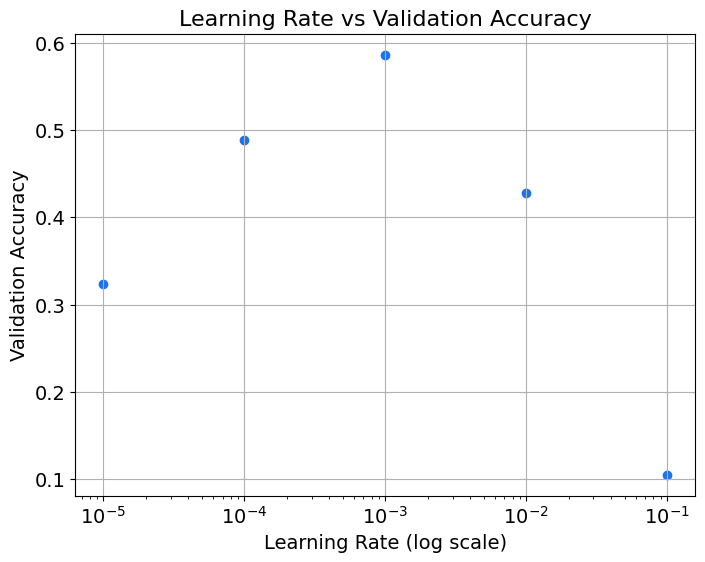

In [10]:
helper_utils1.plot_results(learning_rates, accuracies)

In [11]:
def evaluate_metrics(model, val_dataloader, device, num_classes=10):
    """Evaluates the model on a given dataset using multiple metrics.
    Args:
        model (torch.nn.Module): The PyTorch model to be evaluated.
        val_dataloader (DataLoader): The DataLoader containing the validation data.
        device (torch.device): The device (e.g., 'cuda' or 'cpu') to run the evaluation on.
        num_classes (int, optional): The number of classes in the dataset. Defaults to 10.
    Returns:
        tuple: A tuple containing the computed accuracy, precision, recall, and F1 score.
    """
    # Set the model to evaluation mode
    model.eval()

    # Initialize accuracy metric
    accuracy_metric = torchmetrics.Accuracy(
        task="multiclass", num_classes=num_classes, average="macro"
    ).to(device)

    ### START CODE HERE ###

    # Initialize precision metric using `torchmetrics.Precision`
    precision_metric = torchmetrics.Precision(
        task="multiclass", num_classes=num_classes, average="macro"
    ).to(device)  # <-- don't forget to move to device!

    # Initialize recall metric using `torchmetrics.Recall`
    recall_metric = torchmetrics.Recall(
        task="multiclass", num_classes=num_classes, average="macro"
    ).to(device)

    # Initialize F1 score metric using `torchmetrics.F1Score`
    f1_metric = torchmetrics.F1Score(
        task="multiclass", num_classes=num_classes, average="macro"
    ).to(device)

    ### END CODE HERE ###

    # Disable gradient computation during evaluation
    with torch.no_grad():
        # Iterate over the validation dataloader
        for inputs, labels in val_dataloader:
            # Move inputs and labels to the specified device
            inputs, labels = inputs.to(device), labels.to(device)

            # Get model predictions (raw logits)
            outputs = model(inputs)

            # Get the predicted class by finding the index of the maximum logit
            _, predicted = torch.max(outputs, 1)

            # Update all metrics with the current batch
            accuracy_metric.update(predicted, labels)
            precision_metric.update(predicted, labels)
            recall_metric.update(predicted, labels)
            f1_metric.update(predicted, labels)

    ### START CODE HERE ###

    # Compute the final metrics over the entire dataset
    accuracy = accuracy_metric.compute().item()
    precision = precision_metric.compute().item()
    recall = recall_metric.compute().item()
    f1 = f1_metric.compute().item()

    ### END CODE HERE ###

    return accuracy, precision, recall, f1

In [14]:
def train_and_evaluate_metrics(learning_rate, device, n_epochs=25, batch_size=128, imbalanced=False):
    """Trains and evaluates a model, returning a comprehensive set of metrics.

    This function orchestrates the end-to-end machine learning pipeline for a
    given configuration. It sets a random seed, initializes the model and
    related components, loads data, runs the training loop, and evaluates
    the model's performance using accuracy, precision, recall, and F1-score.

    Args:
        learning_rate (float): The learning rate for the optimizer.
        device: The device (e.g., 'cuda' or 'cpu') for training and evaluation.
        n_epochs (int, optional): The number of training epochs. Defaults to 25.
        batch_size (int, optional): The batch size for dataloaders. Defaults to 128.
        imbalanced (bool, optional): A flag to use an imbalanced dataset.
                                     Defaults to False.

    Returns:
        tuple: A tuple containing the final validation accuracy, precision,
               recall, and F1-score.
    """
    # Set the random seed for reproducibility
    helper_utils1.set_seed(42)

    # Initialize the CNN model and move it to the specified device
    model = SimpleCNN().to(device)

    # Define the loss function for training
    loss_fcn = nn.CrossEntropyLoss()

    # Define the optimizer with the specified learning rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Prepare the training and validation dataloaders
    train_dataloader, val_dataloader = helper_utils1.get_dataset_dataloaders(batch_size=batch_size, imbalanced=imbalanced)

    # Call the main training loop to train the model
    helper_utils1.train_model(model=model, optimizer=optimizer, loss_fcn=loss_fcn, train_dataloader=train_dataloader, device=device, n_epochs=n_epochs)

    # Evaluate the trained model to get a full set of performance metrics
    accuracy, precision, recall, f1 = evaluate_metrics(model, val_dataloader, device)

    # Print the final results for this configuration
    print(
        f"Learning Rate: {learning_rate}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}"
    )
    # Return the computed performance metrics
    return accuracy, precision, recall, f1

In [ ]:
dict_metrics = []

# Loop through different learning rates and collect metrics
for lr in learning_rates:

    # Train and evaluate the model, collecting metrics, for a given learning rate
    n_epochs = 25
    batch_size = 128
    acc, prec, rec, f1 = train_and_evaluate_metrics(learning_rate=lr, device=device, n_epochs=n_epochs, batch_size=batch_size)

    metrics_lr = {
        "learning_rate": lr,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
    }

    dict_metrics.append(metrics_lr)

# Convert the list of dictionaries to a DataFrame for easier plotting
df_metrics = pd.DataFrame(dict_metrics)


helper_utils1.plot_metrics_vs_learning_rate(df_metrics)

Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.2604
Epoch 10 - Train Loss: 2.1798


In [ ]:
# This cell will take about 15 minutes.

dict_metrics = []

# Loop through different batch sizes and collect metrics
batch_sizes = [32, 64, 128]

# Set a fixed learning rate
lr = 0.001  # Medium learning rate

# Set imbalance to True to use imbalanced dataset
imbalanced = True

n_epochs = 25

for bs in batch_sizes:
    acc, prec, rec, f1 = train_and_evaluate_metrics(batch_size=bs, n_epochs=n_epochs, learning_rate=lr, device=device, imbalanced=imbalanced)

    metrics_bs = {
        "batch_size": bs,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
    }
    dict_metrics.append(metrics_bs)

df_metrics = pd.DataFrame(dict_metrics)1

In [ ]:
helper_utils1.plot_metrics_vs_batch_size(df_metrics)

In [1]:
import sys
import time
import warnings

# Redirect stderr to a black hole to catch other potential messages
class BlackHole:
    def write(self, message):
        pass
    def flush(self):
        pass
sys.stderr = BlackHole()

# Ignore Python-level UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import helper_utils2

helper_utils2.set_seed(42)

In [4]:
# # Check device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using device: MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print(f"Using device: CPU")

Using device: CPU


In [6]:
class SimpleCNN(nn.Module):
    """A simple Convolutional Neural Network (CNN) architecture.

    This class defines a two-layer CNN with max pooling, dropout, and
    fully connected layers, suitable for basic image classification tasks.
    """
    def __init__(self):
        """Initializes the layers of the neural network."""
        # Initialize the parent nn.Module class
        super(SimpleCNN, self).__init__()
        # First convolutional layer (3 input channels, 16 output channels, 3x3 kernel)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        # Second convolutional layer (16 input channels, 32 output channels, 3x3 kernel)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # Max pooling layer with a 2x2 window and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        # First fully connected (linear) layer
        self.fc1 = nn.Linear(32 * 8 * 8, 64)
        # Second fully connected (linear) layer, serving as the output layer
        self.fc2 = nn.Linear(64, 10)
        # Dropout layer for regularization
        self.dropout = nn.Dropout(p=0.4)

    def forward(self, x):
        """Defines the forward pass of the network.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, 3, height, width).

        Returns:
            torch.Tensor: The output logits from the network.
        """
        # Apply first convolution, ReLU activation, and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Apply second convolution, ReLU activation, and max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the feature maps for the fully connected layers
        x = x.view(-1, 32 * 8 * 8)
        # Apply the first fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Apply dropout for regularization
        x = self.dropout(x)
        # Apply the final output layer
        x = self.fc2(x)
        return x


def train_and_evaluate(learning_rate, device, n_epochs=25, batch_size=128, p_bar=None):
    """Orchestrates the training and evaluation of a model for a given configuration.

    This function handles the end-to-end workflow: setting a random seed,
    initializing the model, optimizer, loss function, and dataloaders, and then
    running the main training loop.

    Args:
        learning_rate (float): The learning rate for the optimizer.
        device: The device (e.g., 'cuda' or 'cpu') for training and evaluation.
        n_epochs (int, optional): The number of training epochs. Defaults to 25.
        batch_size (int, optional): The batch size for dataloaders. Defaults to 128.
        p_bar (optional): An existing progress bar handler. Defaults to None.

    Returns:
        dict: A dictionary containing the training and validation history
              (loss and accuracy).
    """
    # Set the random seed for reproducibility
    helper_utils2.set_seed(42)

    # Initialize the model and move it to the specified device
    model = SimpleCNN().to(device)

    # Define the optimizer with the specified learning rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Define the loss function
    loss_fn = nn.CrossEntropyLoss()

    # Prepare the training and validation dataloaders
    train_loader, val_loader = helper_utils2.get_dataset_dataloaders(
        batch_size=batch_size
    )

    # Call the main training loop to train the model and get the history
    history = helper_utils2.train_model(
        model=model,
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        optimizer=optimizer,
        loss_fcn=loss_fn,
        device=device,
        n_epochs=n_epochs,
        p_bar=p_bar
    )

    # Return the collected training history
    return history

In [7]:
# Different learning rates to be analyzed
learning_rates = [0.0002, 0.001, 0.005] # Small, medium, and large learning rates

training_curves = []
n_epochs = 25
batch_size = 128

p_bar = helper_utils2.get_p_bar(n_epochs)

# Get the total number of learning rates to check against the index
num_learning_rates = len(learning_rates)

# Train and evaluate the model for each learning rate
for i, lr in enumerate(learning_rates):
    print(f"\nTraining with learning rate: {lr}\n")
    history = train_and_evaluate(learning_rate=lr, n_epochs=n_epochs, batch_size=batch_size, device=device, p_bar=p_bar)
    training_curves.append(history)
    # Only reset the progress bar if it's NOT the last iteration
    if i < num_learning_rates - 1:
        p_bar.reset()

Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/10 [00:00<?, ?it/s]


Training with learning rate: 0.0002



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 5: Training loss: 1.7922, Training accuracy: 0.3589
At epoch 5: Validation loss: 1.7006, Validation accuracy: 0.4105


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 10: Training loss: 1.5873, Training accuracy: 0.4240
At epoch 10: Validation loss: 1.5379, Validation accuracy: 0.4555


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 15: Training loss: 1.4754, Training accuracy: 0.4615
At epoch 15: Validation loss: 1.4398, Validation accuracy: 0.4915


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 20: Training loss: 1.3966, Training accuracy: 0.4969
At epoch 20: Validation loss: 1.3894, Validation accuracy: 0.5045


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 25: Training loss: 1.3423, Training accuracy: 0.5118
At epoch 25: Validation loss: 1.3493, Validation accuracy: 0.5190
Training complete


Training with learning rate: 0.001



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 5: Training loss: 1.5191, Training accuracy: 0.4426
At epoch 5: Validation loss: 1.4708, Validation accuracy: 0.4805


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 10: Training loss: 1.3537, Training accuracy: 0.5000
At epoch 10: Validation loss: 1.3280, Validation accuracy: 0.5340


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 15: Training loss: 1.2219, Training accuracy: 0.5490
At epoch 15: Validation loss: 1.2669, Validation accuracy: 0.5570


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 20: Training loss: 1.0872, Training accuracy: 0.6008
At epoch 20: Validation loss: 1.2109, Validation accuracy: 0.5740


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 25: Training loss: 0.9739, Training accuracy: 0.6400
At epoch 25: Validation loss: 1.2012, Validation accuracy: 0.5850
Training complete


Training with learning rate: 0.005



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 5: Training loss: 1.3999, Training accuracy: 0.4771
At epoch 5: Validation loss: 1.3474, Validation accuracy: 0.5170


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 10: Training loss: 1.1372, Training accuracy: 0.5756
At epoch 10: Validation loss: 1.2930, Validation accuracy: 0.5275


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 15: Training loss: 0.9635, Training accuracy: 0.6346
At epoch 15: Validation loss: 1.2907, Validation accuracy: 0.5665


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 20: Training loss: 0.7988, Training accuracy: 0.6939
At epoch 20: Validation loss: 1.3981, Validation accuracy: 0.5645


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 25: Training loss: 0.7349, Training accuracy: 0.7125
At epoch 25: Validation loss: 1.4585, Validation accuracy: 0.5610
Training complete



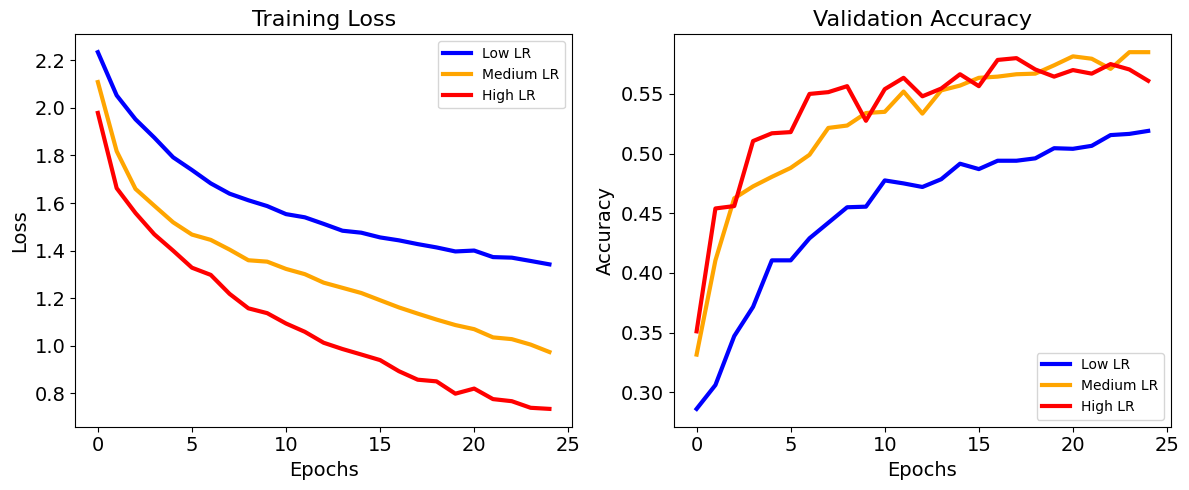

In [8]:
colors = ['blue', 'orange', 'red']
labels = ['Low LR', 'Medium LR', 'High LR']

helper_utils2.plot_learning_curves(colors, labels, training_curves)

# Each color corresponds to a different learning rate: blue for low, orange for medium, and red for high.

In [9]:
helper_utils2.set_seed(42)

# Initialize the model, optimizer, loss function, and dataloaders
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005) # start with a high learning rate

In [ ]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2) # reduce the learning rate by 20% it's prior value

In [11]:
loss_fn = nn.CrossEntropyLoss()

train_loader, val_loader = helper_utils2.get_dataset_dataloaders(batch_size=batch_size)

history_LR = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "lr": [],
}


pbar = helper_utils2.NestedProgressBar(
    total_epochs=n_epochs,
    total_batches=len(train_loader),
    epoch_message_freq=5,
    mode="train",
)

for epoch in range(n_epochs):
    pbar.update_epoch(epoch+1)

    # Train the model for one epoch
    train_loss, train_acc = helper_utils2.train_epoch(model, train_loader, optimizer, loss_fn, device, pbar)

    # Evaluate the model on the validation set
    val_loss, val_acc = helper_utils2.evaluate_epoch(model, val_loader, loss_fn, device)

    # Get the current learning rate BEFORE stepping the scheduler.
    # This captures the LR that was just used for the training epoch above.
    current_lr = scheduler.get_last_lr()[0]

    # Step the scheduler (updates the LR for the NEXT epoch)
    scheduler.step()

    pbar.maybe_log_epoch(epoch=epoch+1, message=f"At epoch {epoch+1}: Training loss: {train_loss:.4f}, Training accuracy: {train_acc:.4f}, LR: {current_lr:.6f}")

    pbar.maybe_log_epoch(epoch=epoch+1, message=f"At epoch {epoch+1}: Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}")

    history_LR["train_loss"].append(train_loss)
    history_LR["train_acc"].append(train_acc)
    history_LR["val_loss"].append(val_loss)
    history_LR["val_acc"].append(val_acc)
    history_LR["lr"].append(current_lr)

pbar.close('Training complete with StepLR scheduler')

Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

NameError: name 'scheduler' is not defined

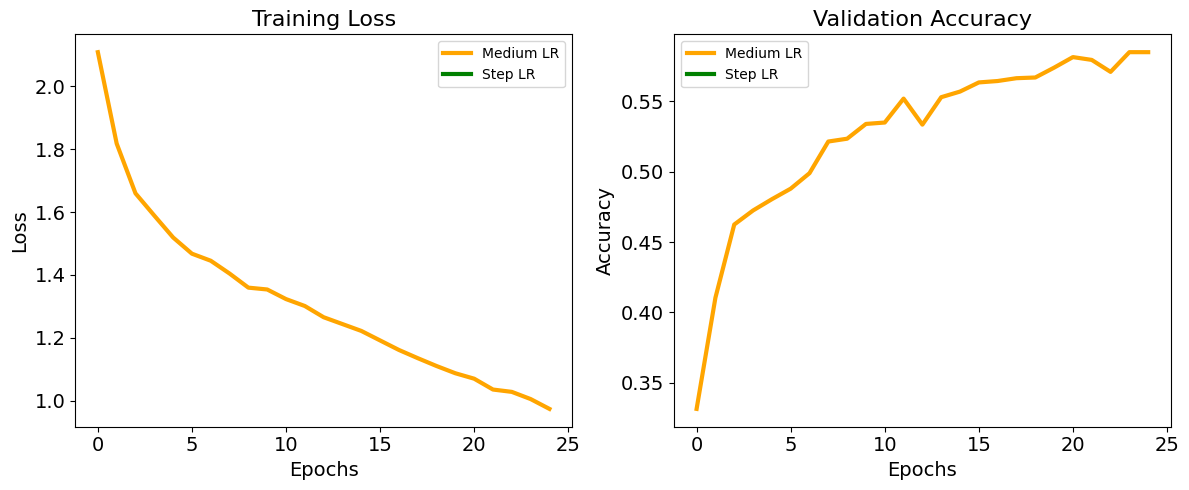

In [12]:
idx = 1
history_constant = training_curves[idx]

colors = ['orange', 'green']
labels = ['Medium LR', 'Step LR']
histories = [history_constant, history_LR]

helper_utils2.plot_learning_curves(colors, labels, histories)

In [13]:
def train_and_evaluate_with_scheduler(model, optimizer, scheduler, device, n_epochs=25, batch_size=128):
    """Trains and evaluates a model using a learning rate scheduler.
    Args:
        model: The neural network model to be trained.
        optimizer: The optimization algorithm.
        scheduler: The learning rate scheduler.
        device: The computing device ('cuda' or 'cpu') to run the training on.
        n_epochs: The total number of training epochs.
        batch_size: The number of samples per batch in the data loaders.

    Returns:
        A dictionary containing the training and validation history
        (loss, accuracy, and learning rate) for each epoch.
    """
    # Set the random seed for reproducibility
    helper_utils2.set_seed(10)

    # Define the loss function
    loss_fn = nn.CrossEntropyLoss()
    # Prepare the training and validation data loaders
    train_loader, val_loader = helper_utils2.get_dataset_dataloaders(
        batch_size=batch_size
    )

    # Initialize a dictionary to store training and validation history
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        'lr': [],
    }

    # Initialize the progress bar for monitoring training
    pbar = helper_utils2.NestedProgressBar(
        total_epochs=n_epochs,
        total_batches=len(train_loader),
        epoch_message_freq=5,
        mode="train",
    )

    # Loop through the specified number of epochs
    for epoch in range(n_epochs):

        # Update the progress bar for the current epoch
        pbar.update_epoch(epoch+1)

        # Train the model for one epoch
        train_loss, train_acc = helper_utils2.train_epoch(model, train_loader, optimizer, loss_fn, device, pbar)
        # Evaluate the model on the validation set
        val_loss, val_acc = helper_utils2.evaluate_epoch(model, val_loader, loss_fn, device)

        # Retrieve the current learning rate from the scheduler
        current_lr = scheduler.get_last_lr()[0]

        # Update the learning rate based on the scheduler type
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            # For schedulers that monitor a metric, pass the metric to the step function
            scheduler.step(val_acc)
        else:
            # For other schedulers, call the step function without arguments
            scheduler.step()

        # Log the training metrics for the current epoch, including the learning rate
        pbar.maybe_log_epoch(epoch=epoch+1, message=f"At epoch {epoch+1}: Training loss: {train_loss:.4f}, Training accuracy: {train_acc:.4f}, LR: {current_lr:.6f}")

        # Log the validation metrics for the current epoch, including the learning rate
        pbar.maybe_log_epoch(epoch=epoch+1, message=f"At epoch {epoch+1}: Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}")

        # Append the metrics for the current epoch to the history dictionary
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history['lr'].append(current_lr)

    # Close the progress bar upon completion of training
    pbar.close('Training complete!')
    # Return the collected training and validation history
    return history

In [14]:
# CosineAnnealingLR
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

scheduler_cosine = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min = 0.0002)

history_cosine = train_and_evaluate_with_scheduler(
    model, optimizer, scheduler_cosine, device, n_epochs=n_epochs, batch_size=batch_size
)

KeyboardInterrupt: 

In [ ]:
# CosineAnnealingLR
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

scheduler_cosine = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min = 0.0002)

history_cosine = train_and_evaluate_with_scheduler(
    model, optimizer, scheduler_cosine, device, n_epochs=n_epochs, batch_size=batch_size
)

In [ ]:
# ReduceLROnPlateau
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

scheduler_plateau = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=3)

history_plateau = train_and_evaluate_with_scheduler(
    model, optimizer, scheduler_plateau, device, n_epochs=n_epochs, batch_size=batch_size
)

In [ ]:
labels = ['Medium LR', 'StepLR', 'CosineAnnealingLR', 'ReducedLRonPlateau']
colors = ['orange', 'green', 'blue', 'purple']

training_curves_new = [history_constant, history_LR, history_cosine, history_plateau]

helper_utils.plot_learning_curves(colors, labels, training_curves_new)